In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzDataset
from torch_model.gru_model import ZzzGRUModule

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["gru"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['gru']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

SEQ_LEN = CFG["gru"]["execution"]["seq_len"]

2023-10-15 08:03:38.887191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-15 08:03:38.887745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-15 08:03:38.887756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_085


In [3]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")
dfs = []
for file in tqdm(files):
    df = pd.read_csv(file)
    dfs.append(df)
train = pd.concat(dfs, axis=0).reset_index(drop=True)
del dfs
gc.collect()

100%|██████████| 277/277 [01:21<00:00,  3.40it/s]


3231

In [4]:
# 標準化
train["anglez"] = (train["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
train["enmo"] = (train["enmo"] - ENMO_MEAN) / ENMO_STD
train["anglez_diff"] = train["anglez"].diff().fillna(0)
train["enmo_diff"] = train["enmo"].diff().fillna(0)

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target,anglez_diff,enmo_diff,fold
0,af91d9a50547,0,2018-02-05T11:15:00-0500,2.747306,-0.405894,NaN,1,0.0,0.0,0.000000,0.0,3
1,af91d9a50547,1,2018-02-05T11:15:05-0500,2.747331,-0.405894,NaN,1,0.0,0.0,0.000025,0.0,3
2,af91d9a50547,2,2018-02-05T11:15:10-0500,2.747416,-0.405894,NaN,1,0.0,0.0,0.000084,0.0,3
3,af91d9a50547,3,2018-02-05T11:15:15-0500,2.747314,-0.405894,NaN,1,0.0,0.0,-0.000101,0.0,3
4,af91d9a50547,4,2018-02-05T11:15:20-0500,2.747441,-0.405894,NaN,1,0.0,0.0,0.000127,0.0,3


(127946340, 12)

In [6]:
# SEQ_LEN ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step")

    for start in range(0, len(df), SEQ_LEN // 2):
        end = start + SEQ_LEN
        if end > len(df):
            end = len(df)
            start = end - SEQ_LEN
            assert start >= 0
        dfs.append(df.iloc[start: end])
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
dataset_oof = ZzzDataset(dfs, 'train', features)
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:19<00:00, 14.13it/s]


((10000, 4), (10000, 2))

In [7]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [8]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzDataset(train_dfs, mode="train", features=features)
    valid_dataset = ZzzDataset(valid_dfs, mode="train", features=features)
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    model = ZzzGRUModule(lr=0.001, dropout=0.0, loss_fn=nn.MSELoss(), input_numerical_size=len(features.all_features()))
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    model = ZzzGRUModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        input_numerical_size=len(features.all_features()),
        loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = model(X.to("cuda")).detach().cpu().numpy()
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.5137, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.1725, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: MSELoss=0.2042, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: MSELoss=0.1699, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: MSELoss=0.1564, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: MSELoss=0.1614, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: MSELoss=0.1583, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: MSELoss=0.1601, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: MSELoss=0.1582, 
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: MSELoss=0.1476, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: MSELoss=0.1489, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: MSELoss=0.1513, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: MSELoss=0.1546, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: MSELoss=0.1556, 
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: MSELoss=0.1556, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=1.1903, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.1595, 


KeyboardInterrupt: 

2492204

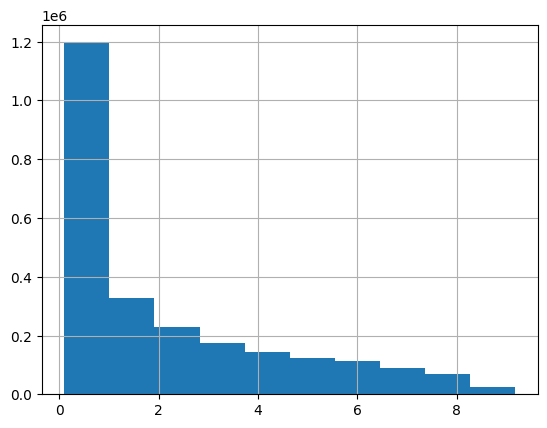

In [12]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [13]:
groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 55/55 [00:05<00:00, 10.50it/s]


In [14]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7571


event   tolerance
onset   12           0.241206
        36           0.639386
        60           0.757494
        90           0.810568
        120          0.831142
        150          0.841291
        180          0.846411
        240          0.855311
        300          0.861947
        360          0.865488
wakeup  12           0.279990
        36           0.654923
        60           0.749210
        90           0.804825
        120          0.826811
        150          0.839596
        180          0.843324
        240          0.851178
        300          0.865848
        360          0.875802
dtype: float64

In [ ]:
%cp -r logs {CFG["output_dir"]}